In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/fotonica04/Documentos/GitHub/Photonics-training/Projects/Hybrid4x4/SimulationFiles')) #Current directory


###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Hybrid4x4/SimulationFiles/'))
# spec_win.loader.exec_module(lumapi)

## Lumapi init

In [13]:
mmi = lumapi.MODE(filename='MMI4x4EME2.lms')

## Functions

In [3]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })


# Format a function/dataset as a polygon
def PolyForm(x,y,ybase):
    y2 = y + ybase
    A = np.zeros((2,len(x)+2))
    
    A[0][1:len(x)+1] = x
    A[1][1:len(x)+1] = y2
    A[0][0] = x[0]
    A[0][len(x)+1] = x[-1]
    A[1][0] = ybase
    A[1][len(x)+1] = ybase
    
    return A

## Assembly parameters

In [32]:
# Body config------------------------------------
BdX_Span = 178e-6 # Body X Span
BdY_Span = 10e-6 # Body y Span


# Ports config-----------------------------------

OutMx = [3.75e-6,-3.75e-6,1.25e-6,-1.25e-6]              # Array of output ports y positions (put 0 on first element to ignore this line)
InMx = [3.75e-6,-3.75e-6,1.25e-6,-1.25e-6]               # Array of input ports y positions (put 0 on first element to ignore this line) 

# If the lines above has to be ignored, use these ones instead: 
InP = 4 # Number of Input ports
OutP = 4 # Number of Output ports
Asy = 0 # Force asymmetry on inputs ports auto-displacement (0 -> Symetry, 1 -> Asymmetry)
         
PYSpan_in = 2e-6 # Input Port Y Span 
PYSpan_out = 2e-6 # Output Port Y Span 


# Tappers config---------------------------------
SetToTappers = 1 # Set tappers as inputs/outputs
TLen = 6e-6 # Tapper Length
TWidth = 2e-6 # Tapper Width

# Bends config--------6------------------------
SBended = 1 # enable S-bends on ports
SBxsp = 8e-6 # S-bend xspan
SBysp = 6e-6 # S-bend yspan


# Mesh config------------------------------------
MeshEnableIn = 1 # enable input mesh insertion
MeshEnableOut = 1 # enable output mesh insertion

MeshOver = [[1000e-9,5e-9,100e-9] , [1000e-9,5e-9,100e-9]] # Override mesh value dx,dy and dz ([[Input Mesh],[Output Mesh]])
#MeshOver = [[100e-9,7e-9,100e-9] , [100e-9,7e-9,100e-9]] # Override mesh value dx,dy and dz ([[Input Mesh],[Output Mesh]])
MeshMultiplier = [[4,4,4] , [4,4,4]] # Mesh multipler value dx,dy and dz ([[Input Mesh],[Output Mesh]])
    

# EME config-------------------------------------
EME_MC_Y = 200 # Number of EME Mesh Cells Y
EME_MC_Z = 100 # Number of EME Mesh Cells Z   
SideCells = 15 # Number of Cells on Input/Output groups

## Assembly

In [33]:
# General & Body settings -----------------------------------

mmi.switchtolayout()
mmi.selectall()
mmi.delete()

TLen = TLen*SetToTappers

if InMx[0] != 0:
    InP = len(InMx)
if OutMx[0] != 0:
    OutP = len(OutMx)

RectInsert(BdX_Span/2,BdX_Span, 0,BdY_Span, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mmi)
mmi.set("name","MMI Body")

RectInsert(BdX_Span/2, BdX_Span+TLen*2+8e-6, 0, BdY_Span*1.5, -0.8e-6, 1.38e-6,
"SiO2 (Glass) - Palik",mmi)
mmi.set("name","Substrate")

# Input/Output ports setting --------------------------------

for i in range(1,InP+1):
    if(InMx[0]==0):
        InY = (i/((Asy+1)*(InP+1))-0.5)*BdY_Span*(1-2*Asy)**i
    else:
        InY = InMx[i-1]
        RectInsert(-TLen-2e-6,4e-6 , InY,0.48e-6, 0,0.22e-6,
        "Si (Silicon) - Palik",mmi)
        mmi.set("name","MMI EnterPort "+ str(i))

for i in range(1,OutP+1):
    if(OutMx[0]==0):
        OutY = (i/(OutP+1)-0.5)*BdY_Span
    else:
        OutY = OutMx[i-1]

    RectInsert(BdX_Span+TLen+2e-6,4e-6, OutY,0.48e-6, 0,0.22e-6,
    "Si (Silicon) - Palik",mmi)
    mmi.set("name","MMI OutPort "+ str(i))


if(SetToTappers == 1):
    for i in range(1,InP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":180,
             "x":-TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth, 
             "width_r":0.48e-6,
             "angle_side":90,  
             "name":"Input Taper "+ str(i)})
        InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
        mmi.set("y",InY)
  
    for i in range(1,OutP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":0,
             "x":BdX_Span+TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth, 
             "width_r":0.48e-6,
             "angle_side":90, 
             "name":"Output Taper "+ str(i)})
        OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
        mmi.set("y",OutY)


# Mesh setting -------------------------------------
if(MeshEnableIn == 1):
    for i in range(InP):
        mmi.addmesh()
        mmi.set({"x":-1e-6-TLen/2, "x span":2e-6 + TLen,
                "y span":TWidth*1.2, "z":0, "z span":1.8e-6})
        InY = mmi.getnamed("MMI EnterPort "+ str(i+1),"y")
        mmi.set("y",InY)
        mmi.set("name","input_mesh " + str(i+1))
        mmi.set({"dx":MeshOver[0][0], "dy":MeshOver[0][1], "dz":MeshOver[0][2]})

if(MeshEnableOut == 1):
    for i in range(OutP):
        mmi.addmesh()
        mmi.set({"x":BdX_Span + 1e-6+TLen/2, "x span":2e-6 + TLen,
                 "y span":TWidth*1.2, "z":0, "z span":1.8e-6})
        OutY = mmi.getnamed("MMI OutPort "+ str(i+1),"y")
        mmi.set("y",OutY)
        mmi.set("name","output_mesh " + str(i+1))
        mmi.set({"dx":MeshOver[1][0], "dy":MeshOver[1][1], "dz":MeshOver[1][2]})


# EME setting ----------------------------------------------
mmi.addeme()

mmi.set({"allow custom eigensolver settings":1 ,"display cells":1, "number of cell groups":5, "wavelength":1547.5e-9})
mmi.set("group spans",np.transpose([2e-6, TLen, BdX_Span, TLen, 2e-6]))      
mmi.set({"cells":np.transpose([1, SideCells, 1, SideCells, 1]),
         "subcell method":np.transpose([0, 1, 0, 1, 0]), # 0 = none,  1 = CVCS
         "modes":np.transpose([21, 21, 30, 21, 21])})

mmi.set({"x min":(-2*TLen-4e-6)/2 ,
     "y":0, "y span":1.15*BdY_Span,
     "z":0, "z span":1.8e-6})

mmi.set({"y min bc":"PML", "y max bc":"PML",
     "z min bc":"Symmetric", "z max bc":"PML",
     "mesh cells y":EME_MC_Y, "mesh cells z":EME_MC_Z})


# EME Ports setting -----------------------------------------
mmi.selectpartial("EME::Ports::port")
mmi.delete()
for i in range(1,InP+1):
    mmi.addemeport()
    InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
    mmi.set({"use full simulation span":0,
    "port location":"left",
    "y":InY, "y span":PYSpan_in,
    "z":0, "z span":1.8e-6})
  
for i in range(1,OutP+1):
    mmi.addemeport()
    OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
    mmi.set({"use full simulation span":0,
    "port location":"right",
    "y":OutY, "y span":PYSpan_out,
    "z":0, "z span":1.8e-6})  


# Monitor setting -----------------------------------------
mmi.addemeprofile()
mmi.set({"x":BdX_Span/2, "x span":BdX_Span+2*TLen+4e-6, "y span":1.15*BdY_Span})

## Assembly FDE

In [42]:
mmi.switchtolayout()
mmi.select("FDE")
mmi.delete()
mmi.addfde()

mmi.set("solver type","2D X normal")
mmi.set({"mesh cells y":500,"mesh cells z":500})
mmi.set({"y min bc":"PML","y max bc":"PML","z min bc":"PML","z max bc":"PML"})
mmi.set({"x":-TLen-1.5e-6, "y":3.8e-6, "y span":1.5*PYSpan_in, "z":0e-6, "z span":8*220e-9,}) # Single port
#mmi.set({"x":-TLen-1.5e-6, "y":0e-6, "y span":BdY_Span, "z":0e-6, "z span":8*220e-9,}) # All ports

## Get imbalance and excess loss

In [27]:
mmi.setemeanalysis('wavelength sweep',1)
mmi.setemeanalysis('start wavelength',1530e-9)
mmi.setemeanalysis('stop wavelength',1565e-9)
mmi.setemeanalysis('number of wavelength points',200)
mmi.emesweep('wavelength sweep')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


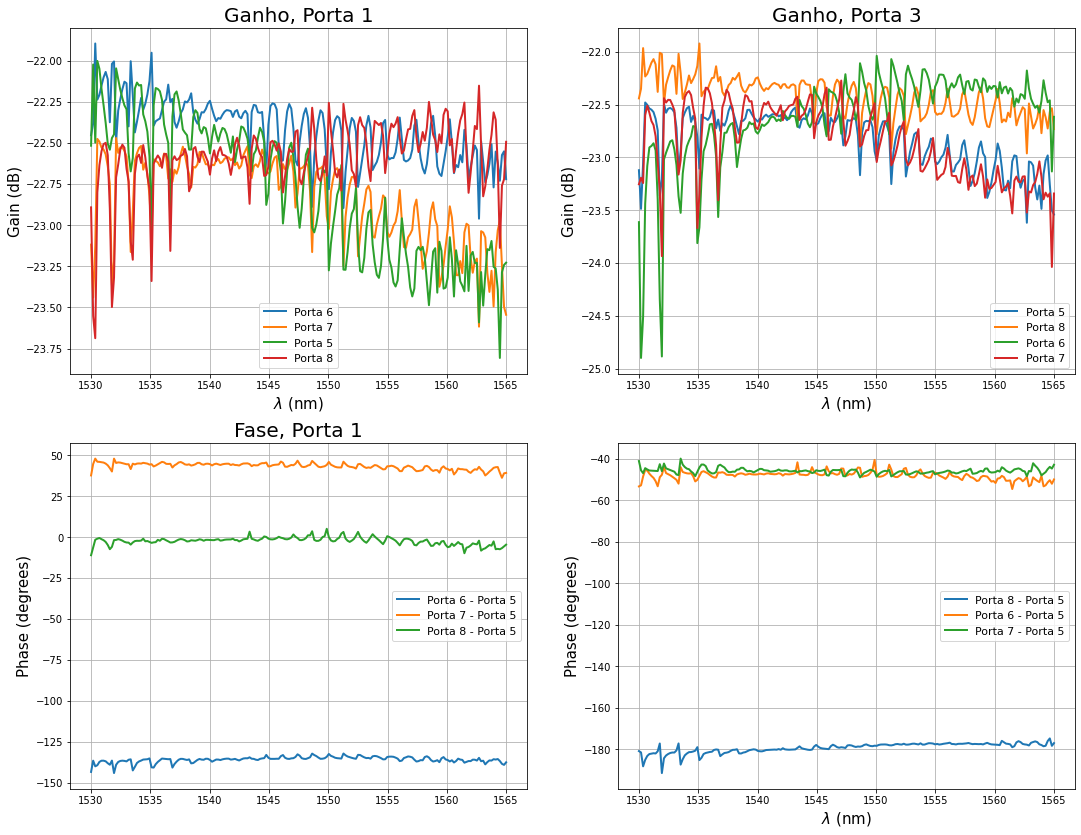

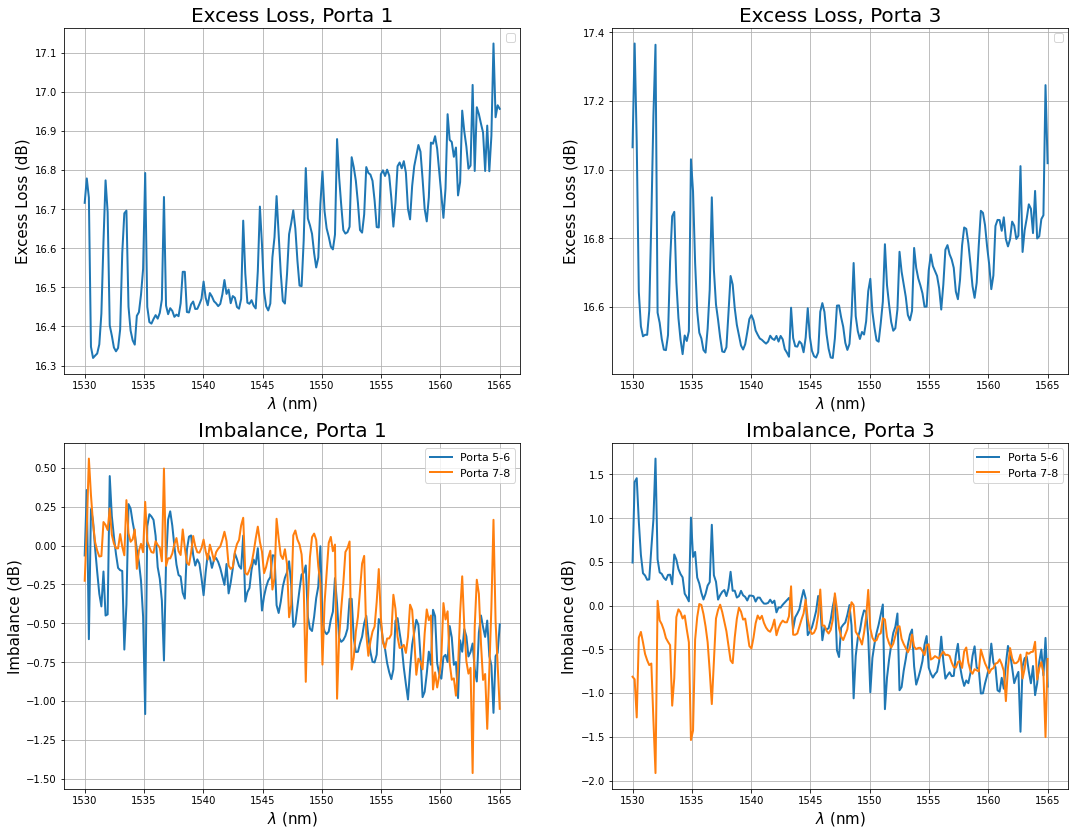

In [33]:
S= mmi.getemesweep('S_wavelength_sweep')
S.keys()
fig, ax= plt.subplots(2,2,figsize=(18,14))
ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s51']**2)),linewidth = 2,label = 'Porta 6')
ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s61']**2)),linewidth = 2,label = 'Porta 7')
# ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s71']**2)),linewidth = 2,label = 'Porta 7')
# ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s81']**2)),linewidth = 2,label = 'Porta 8')
ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s31']**2)),linewidth = 2,label = 'Porta 5')
ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s41']**2)),linewidth = 2,label = 'Porta 8')
ax[0][0].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[0][0].set_ylabel(r'Gain (dB)',fontsize =15)
ax[0][0].set_title('Ganho, Porta 1',fontsize =20)
ax[0][0].legend(fontsize = 11)
ax[0][0].grid()

# ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s54']**2)),linewidth = 2,label = 'Porta 5')
# ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s64']**2)),linewidth = 2,label = 'Porta 6')
# ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s74']**2)),linewidth = 2,label = 'Porta 7')
# ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s84']**2)),linewidth = 2,label = 'Porta 8')
ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s32']**2)),linewidth = 2,label = 'Porta 5')
ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s42']**2)),linewidth = 2,label = 'Porta 8')
ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s52']**2)),linewidth = 2,label = 'Porta 6')
ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s62']**2)),linewidth = 2,label = 'Porta 7')
ax[0][1].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[0][1].set_ylabel(r'Gain (dB)',fontsize =15)
ax[0][1].set_title('Ganho, Porta 3',fontsize =20)
ax[0][1].legend(fontsize = 11)
ax[0][1].grid()

# ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s51'])) - np.unwrap(np.angle(S['s61'])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
# ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s61'])) - np.unwrap(np.angle(S['s31'])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
# ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s71'])) - np.unwrap(np.angle(S['s81'])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
# ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s81'])) - np.unwrap(np.angle(S['s51'])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s51'])) - np.unwrap(np.angle(S['s31'])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 5')
ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s61'])) - np.unwrap(np.angle(S['s31'])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 5')
ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s41'])) - np.unwrap(np.angle(S['s31'])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][0].set_ylabel(r'Phase (degrees)',fontsize =15)
ax[1][0].set_title('Fase, Porta 1',fontsize =20)
ax[1][0].legend(fontsize = 11)
ax[1][0].grid()

# ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s54'])) - np.unwrap(np.angle(S['s64'])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
# ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s64'])) - np.unwrap(np.angle(S['s74'])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
# ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s74'])) - np.unwrap(np.angle(S['s84'])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
# ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s84'])) - np.unwrap(np.angle(S['s54'])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s42'])) - np.unwrap(np.angle(S['s32'])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s52'])) - np.unwrap(np.angle(S['s32'])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 5')
ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s62'])) - np.unwrap(np.angle(S['s32'])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 5')
ax[1][1].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[1][1].set_ylabel(r'Phase (degrees)',fontsize =15)
ax[1][1].legend(fontsize=11)
ax[1][1].grid()
# Exc3 = -10*np.log10( ( (np.abs(S['s54'])**2) + (np.abs(S['s64'])**2) + (np.abs(S['s74'])**2) + (np.abs(S['s84'])**2) ) )

# imb1_o5o6 = 10*np.log10(np.abs(S['s51'])**2 / np.abs(S['s61'])**2)
# imb1_o7o8 = 10*np.log10(np.abs(S['s71'])**2 / np.abs(S['s81'])**2)
# imb3_o5o6 = 10*np.log10(np.abs(S['s54'])**2 / np.abs(S['s64'])**2)
# imb3_o7o8 = 10*np.log10(np.abs(S['s74'])**2 / np.abs(S['s84'])**2)

Exc1 = -10*np.log10( ( (np.abs(S['s51'])**2) + (np.abs(S['s61'])**2) + (np.abs(S['s31'])**2) + (np.abs(S['s41'])**2) ) )
Exc3 = -10*np.log10( ( (np.abs(S['s52'])**2) + (np.abs(S['s62'])**2) + (np.abs(S['s32'])**2) + (np.abs(S['s42'])**2) ) )

imb1_o5o6 = 10*np.log10(np.abs(S['s31'])**2 / np.abs(S['s51'])**2)
imb1_o7o8 = 10*np.log10(np.abs(S['s61'])**2 / np.abs(S['s41'])**2)
imb3_o5o6 = 10*np.log10(np.abs(S['s32'])**2 / np.abs(S['s52'])**2)
imb3_o7o8 = 10*np.log10(np.abs(S['s62'])**2 / np.abs(S['s42'])**2)

fig, ax= plt.subplots(2,2,figsize=(18,14))
ax[0][0].plot(S['wavelength']*1e9,Exc1,linewidth = 2)
ax[0][0].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[0][0].set_ylabel(r'Excess Loss (dB)',fontsize =15) 
ax[0][0].set_title('Excess Loss, Porta 1',fontsize =20) 
ax[0][0].legend(fontsize = 11)
ax[0][0].grid()

ax[0][1].plot(S['wavelength']*1e9,Exc3,linewidth = 2)
ax[0][1].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[0][1].set_ylabel(r'Excess Loss (dB)',fontsize =15)
ax[0][1].set_title('Excess Loss, Porta 3',fontsize =20)
ax[0][1].legend(fontsize = 11)
ax[0][1].grid()

ax[1][0].plot(S['wavelength']*1e9,imb1_o5o6,linewidth = 2,label = 'Porta 5-6')
ax[1][0].plot(S['wavelength']*1e9,imb1_o7o8,linewidth = 2,label = 'Porta 7-8')
ax[1][0].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[1][0].set_ylabel(r'Imbalance (dB)',fontsize =15)
ax[1][0].set_title('Imbalance, Porta 1',fontsize =20)
ax[1][0].legend(fontsize = 11)
ax[1][0].grid()

ax[1][1].plot(S['wavelength']*1e9,imb3_o5o6,linewidth = 2,label = 'Porta 5-6')
ax[1][1].plot(S['wavelength']*1e9,imb3_o7o8,linewidth = 2,label = 'Porta 7-8')
ax[1][1].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[1][1].set_ylabel(r'Imbalance (dB)',fontsize =15)
ax[1][1].set_title('Imbalance, Porta 3',fontsize =20)
ax[1][1].legend(fontsize = 11)
ax[1][1].grid()

In [36]:
mmi.setemeanalysis('propagation sweep',1)
mmi.setemeanalysis('parameter','group span 3')
mmi.setemeanalysis('start',170e-6)
mmi.setemeanalysis('stop',190e-6)
mmi.setemeanalysis('number of points',200)
mmi.emesweep('propagation sweep')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


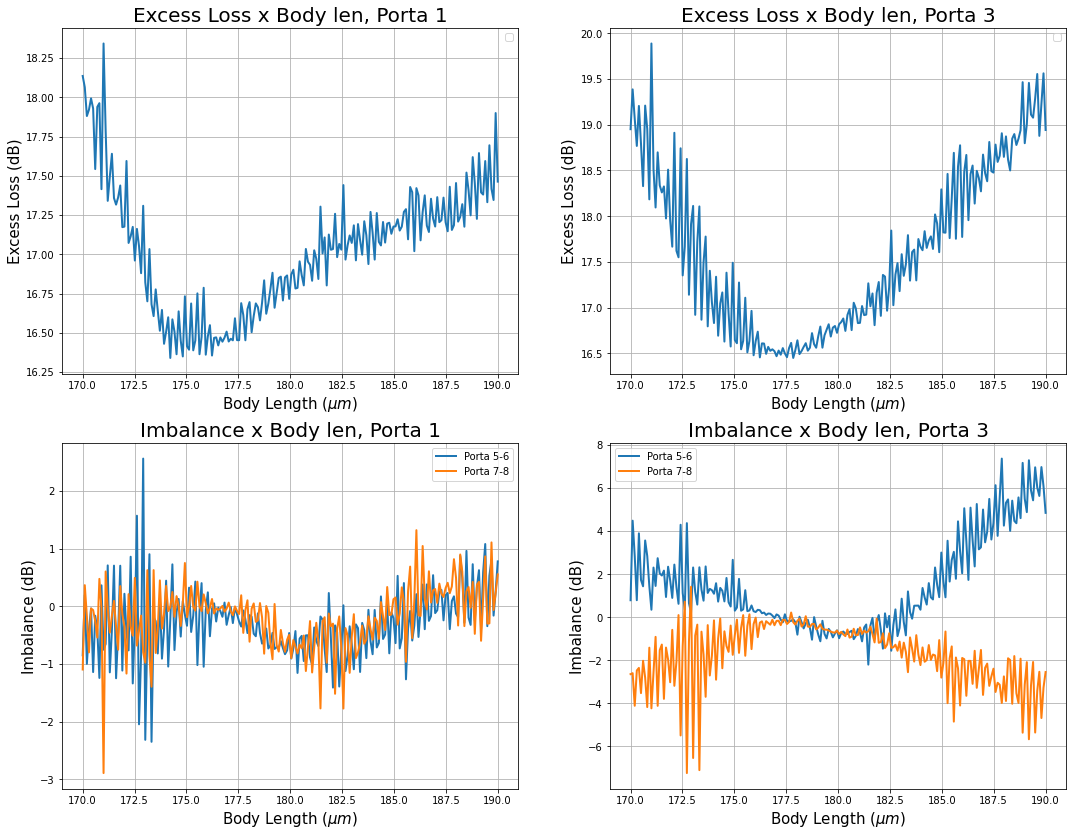

In [38]:
S= mmi.getemesweep('S')
#print(S.keys())

# imb1_o5o6 = 10*np.log10(np.abs(S['s51'])**2 / np.abs(S['s61'])**2)
# imb1_o7o8 = 10*np.log10(np.abs(S['s71'])**2 / np.abs(S['s81'])**2)
# imb2_o5o6 = 10*np.log10(np.abs(S['s54'])**2 / np.abs(S['s64'])**2)
# imb2_o7o8 = 10*np.log10(np.abs(S['s74'])**2 / np.abs(S['s84'])**2)

# Exc1 = -10*np.log10( ( (np.abs(S['s51'])**2) + (np.abs(S['s61'])**2) + (np.abs(S['s71'])**2) + (np.abs(S['s81'])**2) ) )
# Exc2 = -10*np.log10( ( (np.abs(S['s54'])**2) + (np.abs(S['s64'])**2) + (np.abs(S['s74'])**2) + (np.abs(S['s84'])**2) ) )

imb1_o5o6 = 10*np.log10(np.abs(S['s31'])**2 / np.abs(S['s51'])**2)
imb1_o7o8 = 10*np.log10(np.abs(S['s61'])**2 / np.abs(S['s41'])**2)
imb2_o5o6 = 10*np.log10(np.abs(S['s32'])**2 / np.abs(S['s52'])**2)
imb2_o7o8 = 10*np.log10(np.abs(S['s62'])**2 / np.abs(S['s42'])**2)

Exc1 = -10*np.log10( ( (np.abs(S['s51'])**2) + (np.abs(S['s61'])**2) + (np.abs(S['s31'])**2) + (np.abs(S['s41'])**2) ) )
Exc2 = -10*np.log10( ( (np.abs(S['s52'])**2) + (np.abs(S['s62'])**2) + (np.abs(S['s32'])**2) + (np.abs(S['s42'])**2) ) )

fig, ax= plt.subplots(2,2,figsize=(18,14))
ax[1][0].plot(S['group_span_3']*1e6,imb1_o5o6, linewidth = 2,label = 'Porta 5-6')
ax[1][0].plot(S['group_span_3']*1e6,imb1_o7o8, linewidth = 2,label = 'Porta 7-8')
ax[1][0].set_xlabel('Body Length ($\mu m$)',fontsize =15)
ax[1][0].set_ylabel(r'Imbalance (dB)',fontsize =15)
ax[1][0].set_title('Imbalance x Body len, Porta 1',fontsize =20)
ax[1][0].legend()
ax[1][0].grid()

ax[0][0].plot(S['group_span_3']*1e6,Exc1, linewidth = 2)
ax[0][0].set_xlabel('Body Length ($\mu m$)',fontsize =15)
ax[0][0].set_ylabel(r'Excess Loss (dB)',fontsize =15)
ax[0][0].set_title('Excess Loss x Body len, Porta 1',fontsize =20)
ax[0][0].legend()
ax[0][0].grid()

ax[1][1].plot(S['group_span_3']*1e6,imb2_o5o6, linewidth = 2,label = 'Porta 5-6')
ax[1][1].plot(S['group_span_3']*1e6,imb2_o7o8, linewidth = 2,label = 'Porta 7-8')
ax[1][1].set_xlabel('Body Length ($\mu m$)',fontsize =15)
ax[1][1].set_ylabel(r'Imbalance (dB)',fontsize =15)
ax[1][1].set_title('Imbalance x Body len, Porta 3',fontsize =20)
ax[1][1].legend()
ax[1][1].grid()

ax[0][1].plot(S['group_span_3']*1e6,Exc2, linewidth = 2)
ax[0][1].set_xlabel('Body Length ($\mu m$)',fontsize =15)
ax[0][1].set_ylabel(r'Excess Loss (dB)',fontsize =15)
ax[0][1].set_title('Excess Loss x Body len, Porta 3',fontsize =20)
ax[0][1].legend()
ax[0][1].grid()

## Get Field profile

In [17]:
mmi.emepropagate()

Text(0.5, 1.0, 'Field Monitor Log Scale')

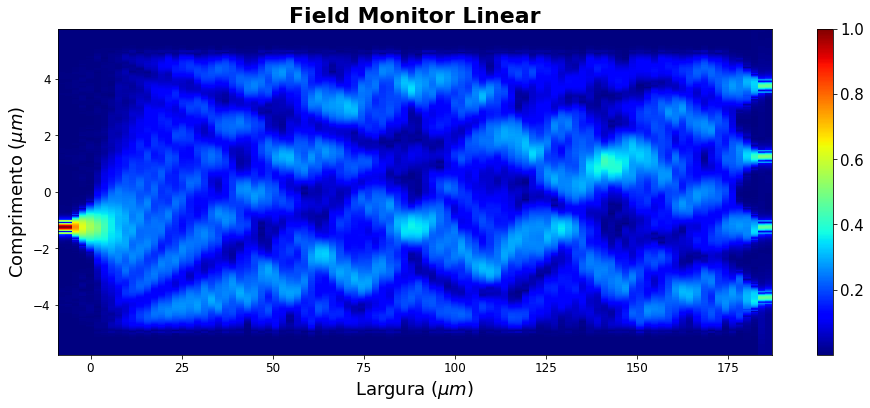

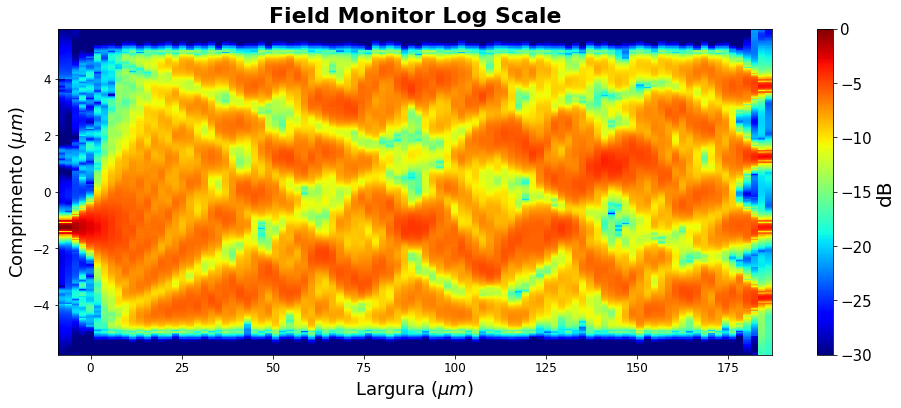

In [26]:
field = mmi.getresult('monitor','field profile')
x = field['x']
y = field['y']
E = field['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])

plt.figure(figsize=(16,6))
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E/(np.max(E)),cmap = 'jet')
plt.xlabel('Largura ($\mu m$)',fontsize=18)
plt.ylabel('Comprimento ($\mu m$)',fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.title("Field Monitor Linear", fontsize = 22, fontweight='bold')

E = 10*np.log10(E/(np.max(E)))


plt.figure(figsize=(16,6))
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Largura ($\mu m$)',fontsize=18)
plt.ylabel('Comprimento ($\mu m$)',fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbar = plt.colorbar()
cbar.set_label(label='dB', size=20)
cbar.ax.tick_params(labelsize=15)
plt.clim(-30,0)
plt.title("Field Monitor Log Scale", fontsize = 22, fontweight='bold')

## Get Txt Data

In [3]:
contents = open('PropResults.txt','r').read()
contSplited = contents.split()
print(contSplited)
print(contents)
open('PropResults.txt','r').close()

SyntaxError: invalid syntax (1508606869.py, line 1)

# Sweeps

## Wmmi sweep

In [12]:
# Sweep configs -----------------------------------------------------------------------------------------------
Name = "Wmmi_sweep" # Sweep name
SPoints = 11       # Sweep points

ParNames = ["MMI_Body","EMEYspan","Substrate",
            
            "Port1Y","Port2Y","Port3Y","Port4Y",
            "Port1Yspan","Port2Yspan","Port3Yspan","Port4Yspan",
            "Port5Y","Port6Y","Port7Y","Port8Y",
            "Port5Yspan","Port6Yspan","Port7Yspan","Port8Yspan",
            
            "MMIPort1Y","MMIPort2Y","MMIPort3Y","MMIPort4Y",
            "TaperPort1Y","TaperPort2Y","TaperPort3Y","TaperPort4Y",
            "MMIPort5Y","MMIPort6Y","MMIPort7Y","MMIPort8Y",
            "TaperPort5Y","TaperPort6Y","TaperPort7Y","TaperPort8Y",
            
            "TaperPort1Yspan","TaperPort2Yspan","TaperPort3Yspan","TaperPort4Yspan",
            "TaperPort5Yspan","TaperPort6Yspan","TaperPort7Yspan","TaperPort8Yspan",
            
            "MeshPort1Y","MeshPort2Y","MeshPort3Y","MeshPort4Y",
            "MeshPort1Yspan","MeshPort2Yspan","MeshPort3Yspan","MeshPort4Yspan",
            "MeshPort5Y","MeshPort6Y","MeshPort7Y","MeshPort8Y",
            "MeshPort5Yspan","MeshPort6Yspan","MeshPort7Yspan","MeshPort8Yspan"] # Parameters

ParPath = ["MMI Body::y span" , "EME::y span" , "Substrate::y span",
           
           "EME::Ports::port_1::y","EME::Ports::port_2::y","EME::Ports::port_3::y","EME::Ports::port_4::y",
           "EME::Ports::port_1::y span","EME::Ports::port_2::y span","EME::Ports::port_3::y span","EME::Ports::port_4::y span",
           "EME::Ports::port_5::y","EME::Ports::port_6::y","EME::Ports::port_7::y","EME::Ports::port_8::y",
           "EME::Ports::port_5::y span","EME::Ports::port_6::y span","EME::Ports::port_7::y span","EME::Ports::port_8::y span",
           
           "MMI EnterPort 1::y","MMI EnterPort 2::y","MMI EnterPort 3::y","MMI EnterPort 4::y",
           "Input Taper 1::y","Input Taper 2::y","Input Taper 3::y","Input Taper 4::y",
           "MMI OutPort 1::y","MMI OutPort 2::y","MMI OutPort 3::y","MMI OutPort 4::y",
           "Output Taper 1::y","Output Taper 2::y","Output Taper 3::y","Output Taper 4::y",
           
           "Input Taper 1::width_l","Input Taper 2::width_l","Input Taper 3::width_l","Input Taper 4::width_l",
           "Output Taper 1::width_l","Output Taper 2::width_l","Output Taper 3::width_l","Output Taper 4::width_l",
           
           "input_mesh 1::y","input_mesh 2::y","input_mesh 3::y","input_mesh 4::y",
           "output_mesh 1::y","output_mesh 2::y","output_mesh 3::y","output_mesh 4::y",
           "input_mesh 1::y span","input_mesh 2::y span","input_mesh 3::y span","input_mesh 4::y span",
           "output_mesh 1::y span","output_mesh 2::y span","output_mesh 3::y span","output_mesh 4::y span"]

RFac = [0.9, 1.1]

SRange = [[RFac[0]*10e-6, RFac[1]*10e-6],[10e-6,12e-6],[10e-6,12e-6],
          
          [RFac[0]*3.8e-6, RFac[1]*3.8e-6],[-RFac[0]*3.8e-6, -RFac[1]*3.8e-6],[RFac[0]*1.2e-6, RFac[1]*1.2e-6],[-RFac[0]*1.2e-6, -RFac[1]*1.2e-6],
          [RFac[0]*2.4e-6, RFac[1]*2.4e-6],[RFac[0]*2.4e-6, RFac[1]*2.4e-6],[RFac[0]*2.4e-6, RFac[1]*2.4e-6],[RFac[0]*2.4e-6, RFac[1]*2.4e-6],
          [RFac[0]*3.8e-6, RFac[1]*3.8e-6],[-RFac[0]*3.8e-6, -RFac[1]*3.8e-6],[RFac[0]*1.2e-6, RFac[1]*1.2e-6],[-RFac[0]*1.2e-6, -RFac[1]*1.2e-6],
          [RFac[0]*2.4e-6, RFac[1]*2.4e-6],[RFac[0]*2.4e-6, RFac[1]*2.4e-6],[RFac[0]*2.4e-6, RFac[1]*2.4e-6],[RFac[0]*2.4e-6, RFac[1]*2.4e-6],

          [RFac[0]*3.8e-6, RFac[1]*3.8e-6],[-RFac[0]*3.8e-6, -RFac[1]*3.8e-6],[RFac[0]*1.2e-6,RFac[1]*1.2e-6],[-RFac[0]*1.2e-6,-RFac[1]*1.2e-6],
          [RFac[0]*3.8e-6, RFac[1]*3.8e-6],[-RFac[0]*3.8e-6, -RFac[1]*3.8e-6],[RFac[0]*1.2e-6,RFac[1]*1.2e-6],[-RFac[0]*1.2e-6,-RFac[1]*1.2e-6],
          [RFac[0]*3.8e-6, RFac[1]*3.8e-6],[-RFac[0]*3.8e-6, -RFac[1]*3.8e-6],[RFac[0]*1.2e-6,RFac[1]*1.2e-6],[-RFac[0]*1.2e-6,-RFac[1]*1.2e-6],
          [RFac[0]*3.8e-6, RFac[1]*3.8e-6],[-RFac[0]*3.8e-6, -RFac[1]*3.8e-6],[RFac[0]*1.2e-6,RFac[1]*1.2e-6],[-RFac[0]*1.2e-6,-RFac[1]*1.2e-6],
          
          [RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],
          [RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],

          [RFac[0]*3.8e-6, RFac[1]*3.8e-6],[-RFac[0]*3.8e-6, -RFac[1]*3.8e-6],[RFac[0]*1.2e-6, RFac[1]*1.2e-6],[-RFac[0]*1.2e-6, -RFac[1]*1.2e-6],
          [RFac[0]*3.8e-6, RFac[1]*3.8e-6],[-RFac[0]*3.8e-6, -RFac[1]*3.8e-6],[RFac[0]*1.2e-6, RFac[1]*1.2e-6],[-RFac[0]*1.2e-6, -RFac[1]*1.2e-6],
          [RFac[0]*2e-6, RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],
          [RFac[0]*2e-6, RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6],[RFac[0]*2e-6,RFac[1]*2e-6]]
 
ResNames = ["SMatrix"] # Results
ResPath = ["EME::user s matrix"]

# Sweep creation ----------------------------------------------------------------------------------------------
mmi.deletesweep(Name)
mmi.addsweep(0)
mmi.setsweep("sweep","name",Name)
mmi.setsweep(Name,"type","Ranges")
mmi.setsweep(Name,"number of points",SPoints)

for i in range(len(ParNames)):
    StructParameter = {"Name":ParNames[i], "Type":"Number",
                    "Parameter":"::model::" + str(ParPath[i]),
                    "Start":SRange[i][0], "Stop":SRange[i][1]}
    mmi.addsweepparameter(Name,StructParameter)

for i in range(len(ResNames)):
    StructResult = {"Name":ResNames[i], "Result":"::model::" + str(ResPath[i])}
    mmi.addsweepresult(Name,StructResult)

dict_keys(['index_1', 'index_2', 'MMI_Body', 'EMEYspan', 'Substrate', 'Port1Y', 'Port2Y', 'Port3Y', 'Port4Y', 'Port1Yspan', 'Port2Yspan', 'Port3Yspan', 'Port4Yspan', 'Port5Y', 'Port6Y', 'Port7Y', 'Port8Y', 'Port5Yspan', 'Port6Yspan', 'Port7Yspan', 'Port8Yspan', 'MMIPort1Y', 'MMIPort2Y', 'MMIPort3Y', 'MMIPort4Y', 'TaperPort1Y', 'TaperPort2Y', 'TaperPort3Y', 'TaperPort4Y', 'MMIPort5Y', 'MMIPort6Y', 'MMIPort7Y', 'MMIPort8Y', 'TaperPort5Y', 'TaperPort6Y', 'TaperPort7Y', 'TaperPort8Y', 'TaperPort1Yspan', 'TaperPort2Yspan', 'TaperPort3Yspan', 'TaperPort4Yspan', 'TaperPort5Yspan', 'TaperPort6Yspan', 'TaperPort7Yspan', 'TaperPort8Yspan', 'MeshPort1Y', 'MeshPort2Y', 'MeshPort3Y', 'MeshPort4Y', 'MeshPort1Yspan', 'MeshPort2Yspan', 'MeshPort3Yspan', 'MeshPort4Yspan', 'MeshPort5Y', 'MeshPort6Y', 'MeshPort7Y', 'MeshPort8Y', 'MeshPort5Yspan', 'MeshPort6Yspan', 'MeshPort7Yspan', 'MeshPort8Yspan', 'user s matrix', 'Lumerical_dataset'])


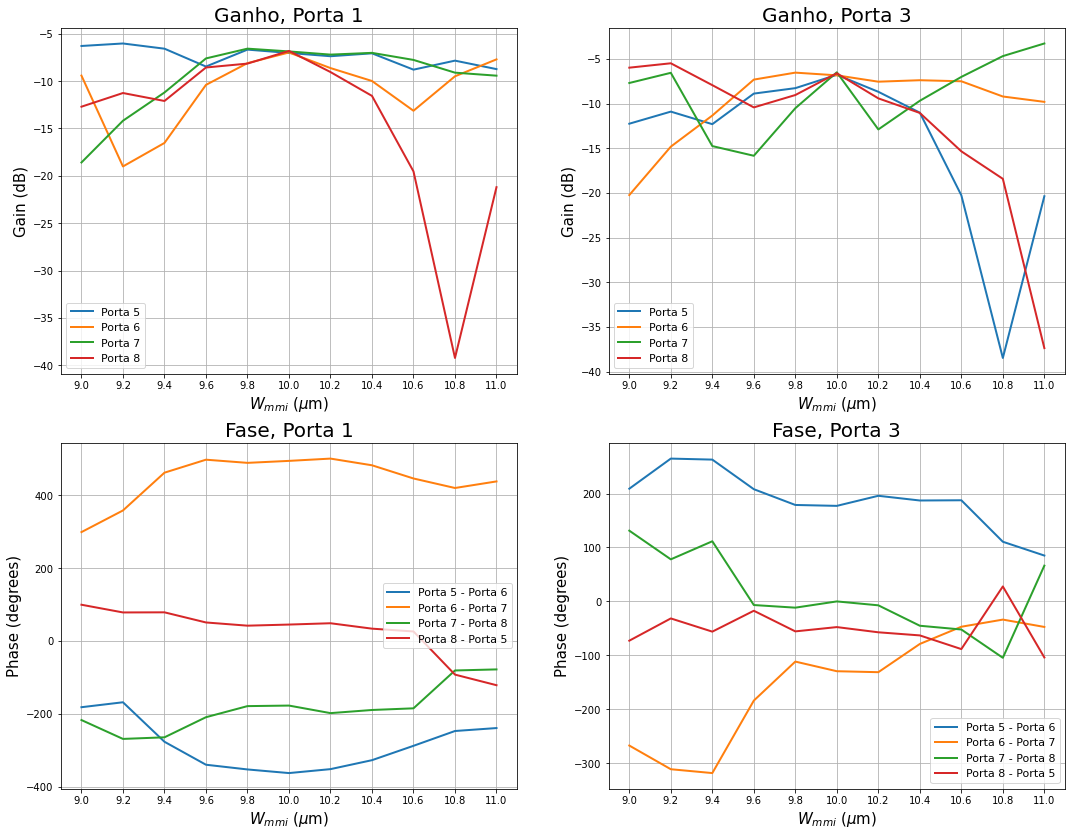

In [14]:
SResult = mmi.getsweepresult("Wmmi_sweep","SMatrix")
SMatrix = SResult['user s matrix']
print(SResult.keys())
WidthArray = np.linspace(9e-6,11e-6, 11)

fig, ax= plt.subplots(2,2,figsize=(18,14))
ax[0][0].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrix[4,0,:]**2)),linewidth = 2,label = 'Porta 5')
ax[0][0].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrix[5,0,:]**2)),linewidth = 2,label = 'Porta 6')
ax[0][0].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrix[6,0,:]**2)),linewidth = 2,label = 'Porta 7')
ax[0][0].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrix[7,0,:]**2)),linewidth = 2,label = 'Porta 8')
ax[0][0].set_xlabel(r'$W_{mmi}$ ($\mu$m)',fontsize =15)
ax[0][0].set_ylabel(r'Gain (dB)',fontsize =15)
ax[0][0].set_title('Ganho, Porta 1',fontsize =20)
ax[0][0].set_xticks(WidthArray*1e6)
ax[0][0].legend(fontsize = 11)
ax[0][0].grid()

ax[0][1].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrix[4,3,:]**2)),linewidth = 2,label = 'Porta 5')
ax[0][1].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrix[5,3,:]**2)),linewidth = 2,label = 'Porta 6')
ax[0][1].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrix[6,3,:]**2)),linewidth = 2,label = 'Porta 7')
ax[0][1].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrix[7,3,:]**2)),linewidth = 2,label = 'Porta 8')
ax[0][1].set_xlabel(r'$W_{mmi}$ ($\mu$m)',fontsize =15)
ax[0][1].set_ylabel(r'Gain (dB)',fontsize =15)
ax[0][1].set_title('Ganho, Porta 3',fontsize =20)
ax[0][1].set_xticks(WidthArray*1e6)
ax[0][1].legend(fontsize = 11)
ax[0][1].grid()

ax[1][0].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrix[4,0,:])) - np.unwrap(np.angle(SMatrix[5,0,:])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
ax[1][0].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrix[5,0,:])) - np.unwrap(np.angle(SMatrix[6,0,:])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
ax[1][0].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrix[6,0,:])) - np.unwrap(np.angle(SMatrix[7,0,:])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
ax[1][0].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrix[7,0,:])) - np.unwrap(np.angle(SMatrix[4,0,:])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][0].set_xlabel(r'$W_{mmi}$ ($\mu$m)',fontsize =15)
ax[1][0].set_ylabel(r'Phase (degrees)',fontsize =15)
ax[1][0].set_title('Fase, Porta 1',fontsize =20)
ax[1][0].set_xticks(WidthArray*1e6)
ax[1][0].legend(fontsize = 11)
ax[1][0].grid()

ax[1][1].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrix[4,3,:])) - np.unwrap(np.angle(SMatrix[5,3,:])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
ax[1][1].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrix[5,3,:])) - np.unwrap(np.angle(SMatrix[6,3,:])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
ax[1][1].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrix[6,3,:])) - np.unwrap(np.angle(SMatrix[7,3,:])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
ax[1][1].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrix[7,3,:])) - np.unwrap(np.angle(SMatrix[4,3,:])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][1].set_xlabel(r'$W_{mmi}$ ($\mu$m)',fontsize =15)
ax[1][1].set_ylabel(r'Phase (degrees)',fontsize =15)
ax[1][1].set_title('Fase, Porta 3',fontsize =20)
ax[1][1].set_xticks(WidthArray*1e6)
ax[1][1].legend(fontsize = 11)
ax[1][1].grid()

## Tapper length sweep

### User S matrix

In [16]:
SPoints = 16       # Sweep points
RFac = [0.5, 4]
EMESpanR = np.linspace(7.9e-6+(RFac[0]-1)*6e-6 ,7.9e-6+(RFac[1]-1)*6e-6, SPoints)
EMEXminR = np.linspace(-(RFac[0]-1)*6e-6 -7.9e-6, -(RFac[1]-1)*6e-6 -7.9e-6, SPoints)
SubstrateR = np.linspace(198e-6, 198e-6 + 2*RFac[1]*6e-6, SPoints)
MMIports1_4R = np.linspace(-8e-6 -(RFac[0]-1)*6e-6, -8e-6 -(RFac[1]-1)*6e-6, SPoints)
MMIports5_8R = np.linspace(186e-6 +(RFac[0]-1)*6e-6, 186e-6 +(RFac[1]-1)*6e-6, SPoints)
TapperLenR = np.linspace(RFac[0]*6e-6, RFac[1]*6e-6, SPoints)

SMatrixData = np.zeros((8,8,SPoints),dtype=complex)

for i in range(SPoints):

    mmi.switchtolayout()
    mmi.select('EME')
    mmi.set("group spans",np.transpose([EMESpanR[i], 178e-6, EMESpanR[i]]))      
    mmi.set("x min",EMEXminR[i])

    mmi.select("Substrate")
    mmi.set("x span",SubstrateR[i])

    mmi.select("MMI EnterPort 1")
    mmi.set("x",MMIports1_4R[i])
    mmi.select("MMI EnterPort 2")
    mmi.set("x",MMIports1_4R[i])
    mmi.select("MMI EnterPort 3")
    mmi.set("x",MMIports1_4R[i])
    mmi.select("MMI EnterPort 4")
    mmi.set("x",MMIports1_4R[i])
    mmi.select("MMI OutPort 1")
    mmi.set("x",MMIports5_8R[i])
    mmi.select("MMI OutPort 2")
    mmi.set("x",MMIports5_8R[i])
    mmi.select("MMI OutPort 3")
    mmi.set("x",MMIports5_8R[i])
    mmi.select("MMI OutPort 4")
    mmi.set("x",MMIports5_8R[i])

    mmi.select("Input Taper 1")
    mmi.set({"len":TapperLenR[i], "x":-3e-6 -TapperLenR[i]/2 + 3e-6})
    mmi.select("Input Taper 2")
    mmi.set({"len":TapperLenR[i], "x":-3e-6 -TapperLenR[i]/2 + 3e-6})
    mmi.select("Input Taper 3")
    mmi.set({"len":TapperLenR[i], "x":-3e-6 -TapperLenR[i]/2 + 3e-6})
    mmi.select("Input Taper 4")
    mmi.set({"len":TapperLenR[i], "x":-3e-6 -TapperLenR[i]/2 + 3e-6})
    mmi.select("Output Taper 1")
    mmi.set({"len":TapperLenR[i], "x":181e-6 +TapperLenR[i]/2 - 3e-6})
    mmi.select("Output Taper 2")
    mmi.set({"len":TapperLenR[i], "x":181e-6 +TapperLenR[i]/2 - 3e-6})
    mmi.select("Output Taper 3")
    mmi.set({"len":TapperLenR[i], "x":181e-6 +TapperLenR[i]/2 - 3e-6})
    mmi.select("Output Taper 4")
    mmi.set({"len":TapperLenR[i], "x":181e-6 +TapperLenR[i]/2 - 3e-6})

    print("Running "+str(i+1)+"/"+str(SPoints)+"...")

    mmi.run()
    mmi.emepropagate()

    SMatrixData[:,:,i] = mmi.getresult("EME","user s matrix")

Running 1/16...
Running 2/16...
Running 3/16...
Running 4/16...
Running 5/16...
Running 6/16...
Running 7/16...
Running 8/16...
Running 9/16...
Running 10/16...
Running 11/16...
Running 12/16...
Running 13/16...
Running 14/16...
Running 15/16...
Running 16/16...


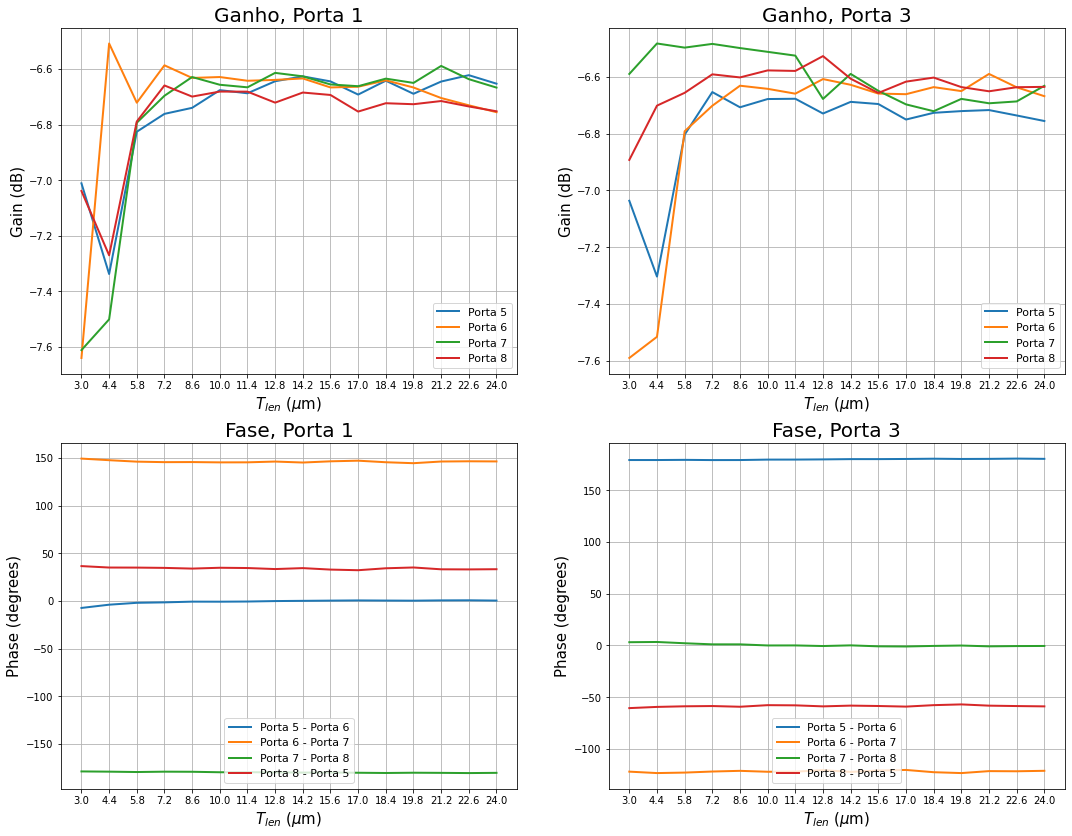

In [18]:
WidthArray = np.linspace(3e-6,24e-6, 16)

fig, ax= plt.subplots(2,2,figsize=(18,14))
ax[0][0].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrixData[4,0,:]**2)),linewidth = 2,label = 'Porta 5')
ax[0][0].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrixData[5,0,:]**2)),linewidth = 2,label = 'Porta 6')
ax[0][0].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrixData[6,0,:]**2)),linewidth = 2,label = 'Porta 7')
ax[0][0].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrixData[7,0,:]**2)),linewidth = 2,label = 'Porta 8')
ax[0][0].set_xlabel(r'$T_{len}$ ($\mu$m)',fontsize =15)
ax[0][0].set_ylabel(r'Gain (dB)',fontsize =15)
ax[0][0].set_title('Ganho, Porta 1',fontsize =20)
ax[0][0].set_xticks(WidthArray*1e6)
ax[0][0].legend(fontsize = 11)
ax[0][0].grid()

ax[0][1].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrixData[4,3,:]**2)),linewidth = 2,label = 'Porta 5')
ax[0][1].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrixData[5,3,:]**2)),linewidth = 2,label = 'Porta 6')
ax[0][1].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrixData[6,3,:]**2)),linewidth = 2,label = 'Porta 7')
ax[0][1].plot(WidthArray*1e6,10*np.log10(np.abs(SMatrixData[7,3,:]**2)),linewidth = 2,label = 'Porta 8')
ax[0][1].set_xlabel(r'$T_{len}$ ($\mu$m)',fontsize =15)
ax[0][1].set_ylabel(r'Gain (dB)',fontsize =15)
ax[0][1].set_title('Ganho, Porta 3',fontsize =20)
ax[0][1].set_xticks(WidthArray*1e6)
ax[0][1].legend(fontsize = 11)
ax[0][1].grid()

ax[1][0].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrixData[4,0,:])) - np.unwrap(np.angle(SMatrixData[5,0,:])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
ax[1][0].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrixData[5,0,:])) - np.unwrap(np.angle(SMatrixData[6,0,:])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
ax[1][0].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrixData[6,0,:])) - np.unwrap(np.angle(SMatrixData[7,0,:])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
ax[1][0].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrixData[7,0,:])) - np.unwrap(np.angle(SMatrixData[4,0,:])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][0].set_xlabel(r'$T_{len}$ ($\mu$m)',fontsize =15)
ax[1][0].set_ylabel(r'Phase (degrees)',fontsize =15)
ax[1][0].set_title('Fase, Porta 1',fontsize =20)
ax[1][0].set_xticks(WidthArray*1e6)
ax[1][0].legend(fontsize = 11)
ax[1][0].grid()

ax[1][1].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrixData[4,3,:])) - np.unwrap(np.angle(SMatrixData[5,3,:])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
ax[1][1].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrixData[5,3,:])) - np.unwrap(np.angle(SMatrixData[6,3,:])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
ax[1][1].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrixData[6,3,:])) - np.unwrap(np.angle(SMatrixData[7,3,:])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
ax[1][1].plot(WidthArray*1e6,180*(np.unwrap(np.angle(SMatrixData[7,3,:])) - np.unwrap(np.angle(SMatrixData[4,3,:])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][1].set_xlabel(r'$T_{len}$ ($\mu$m)',fontsize =15)
ax[1][1].set_ylabel(r'Phase (degrees)',fontsize =15)
ax[1][1].set_title('Fase, Porta 3',fontsize =20)
ax[1][1].set_xticks(WidthArray*1e6)
ax[1][1].legend(fontsize = 11)
ax[1][1].grid()

### Gain graphs

Running 1/6...
Running 2/6...
Running 3/6...
Running 4/6...
Running 5/6...
Running 6/6...


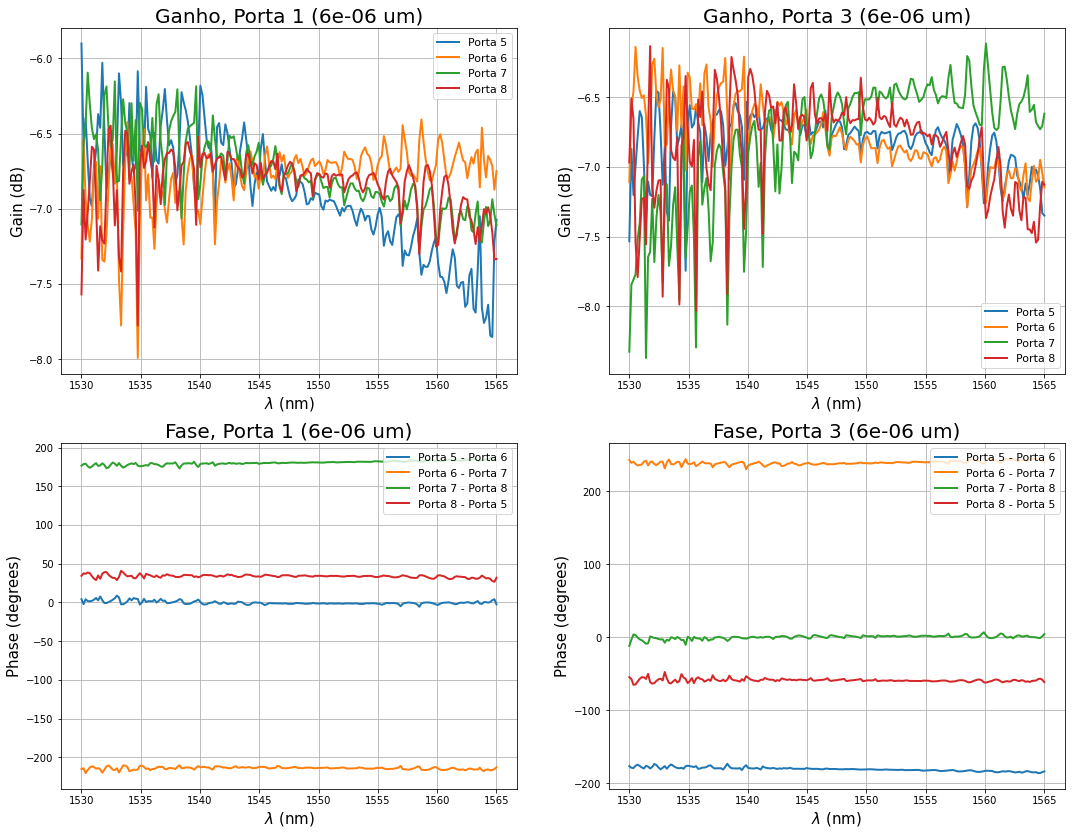

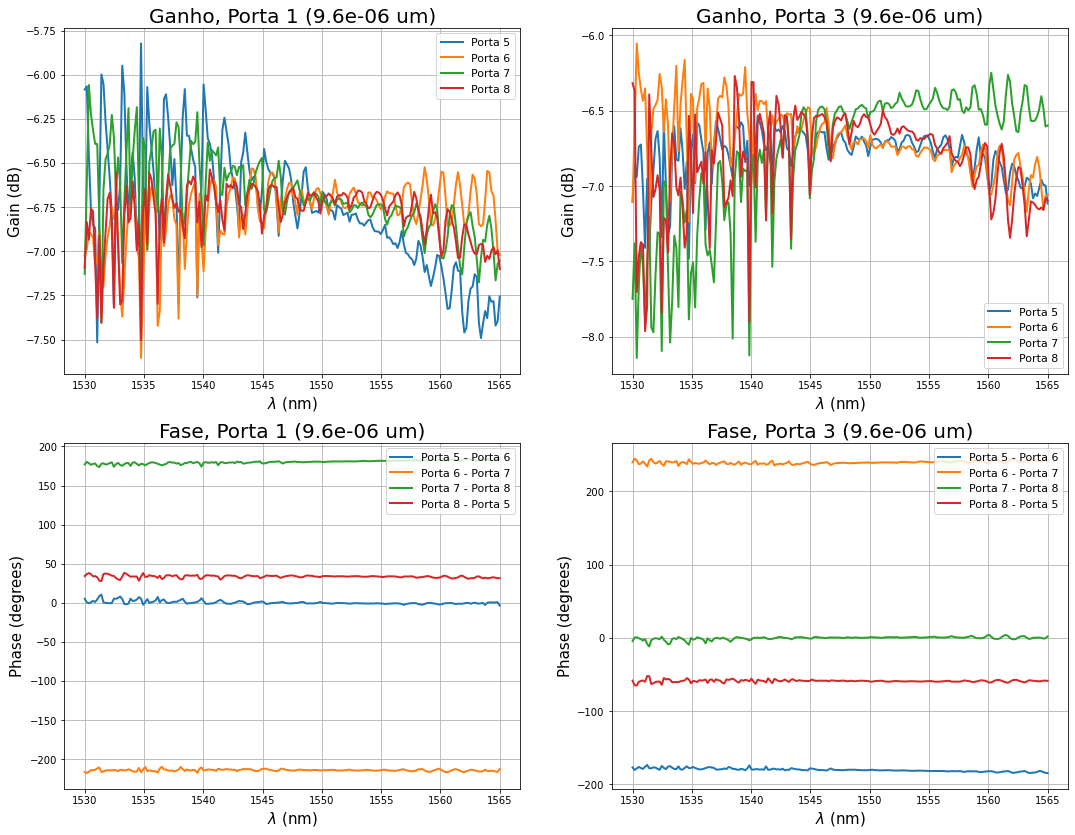

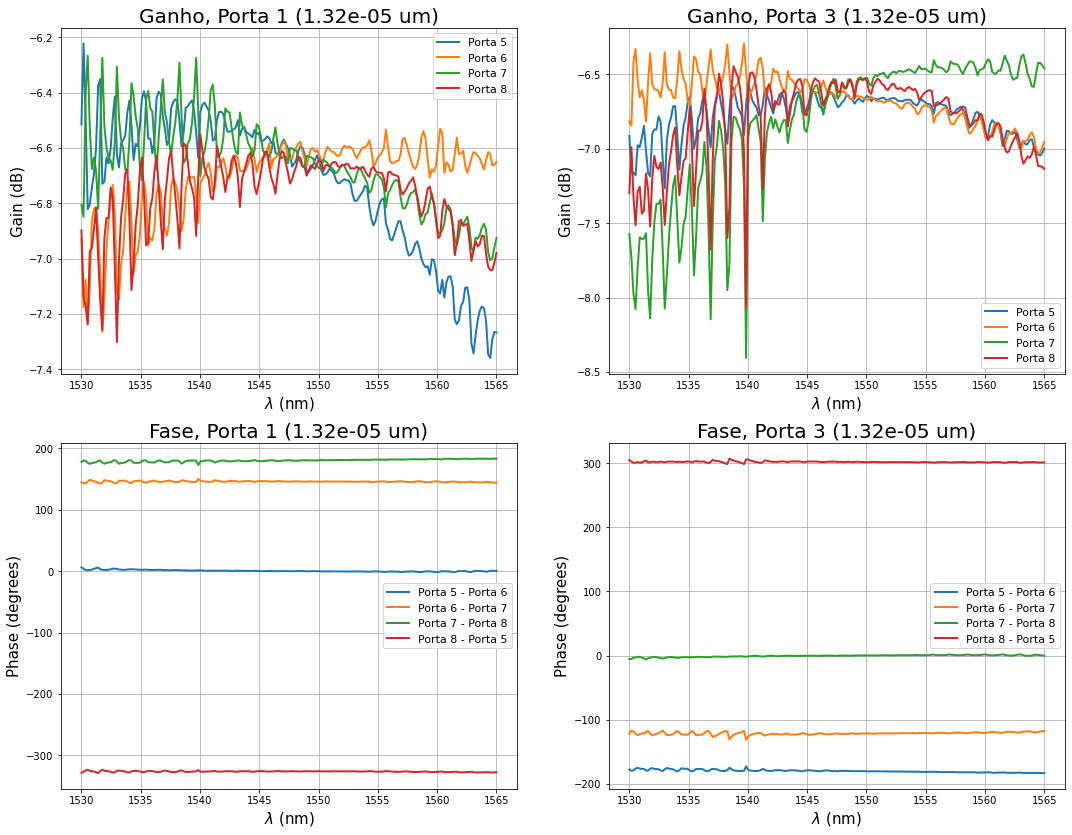

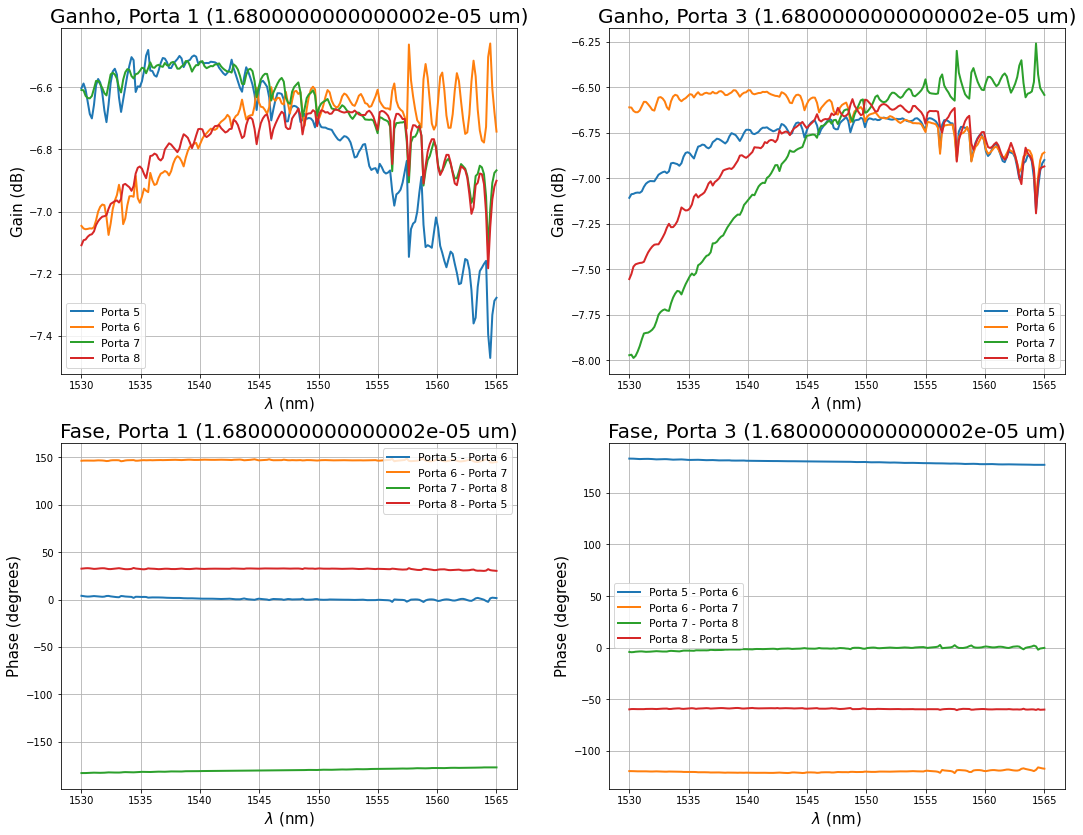

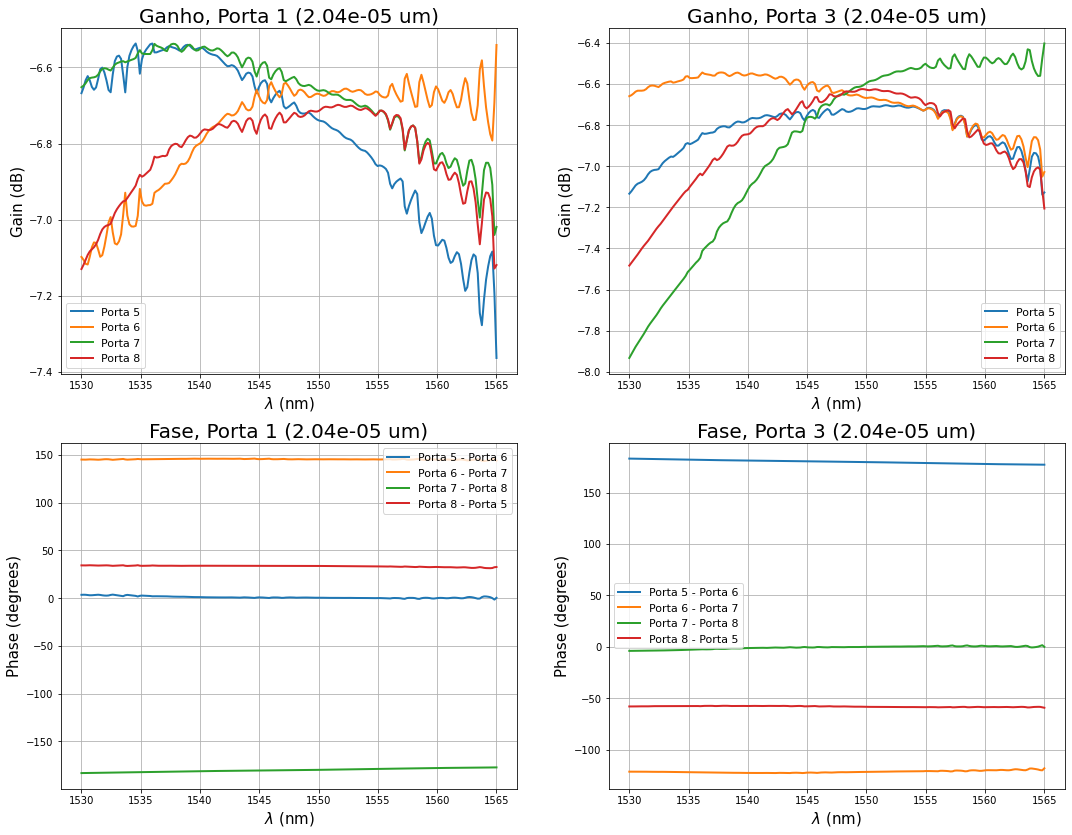

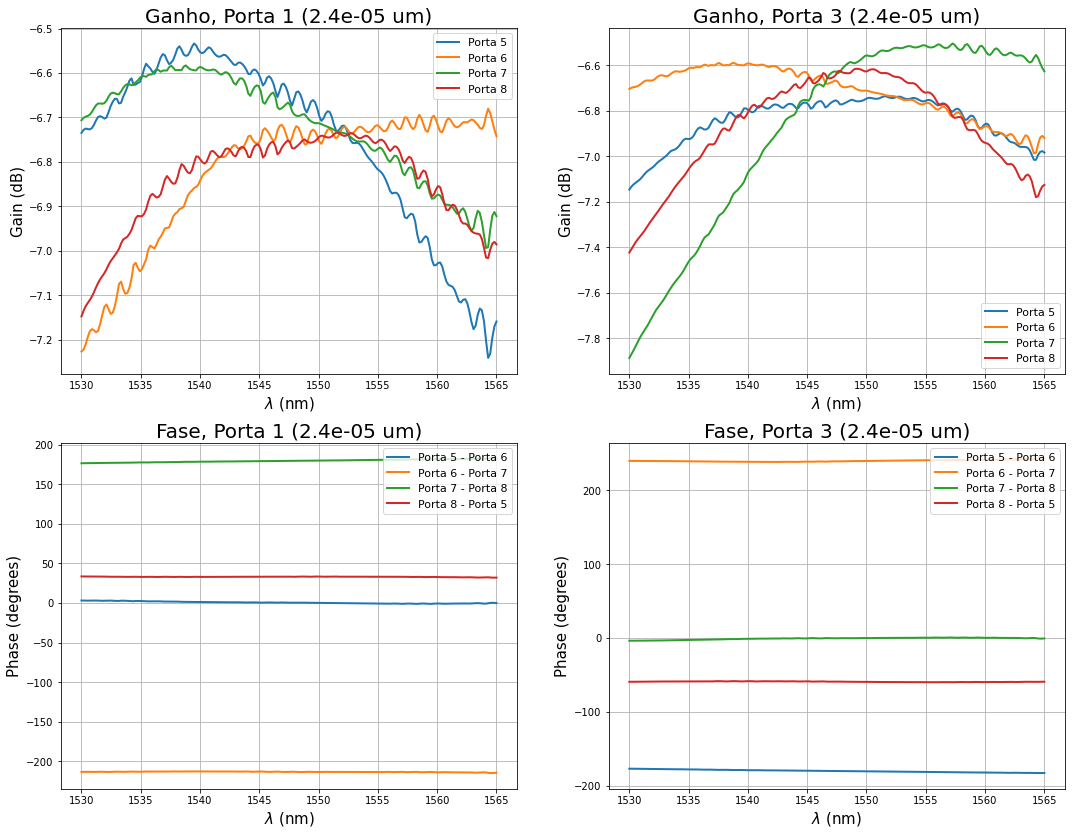

In [20]:
SPoints = 6       # Sweep points
RFac = [1, 4]
EMESpanR = np.linspace(7.9e-6+(RFac[0]-1)*6e-6 ,7.9e-6+(RFac[1]-1)*6e-6, SPoints)
EMEXminR = np.linspace(-(RFac[0]-1)*6e-6 -7.9e-6, -(RFac[1]-1)*6e-6 -7.9e-6, SPoints)
SubstrateR = np.linspace(198e-6, 198e-6 + 2*RFac[1]*6e-6, SPoints)
MMIports1_4R = np.linspace(-8e-6 -(RFac[0]-1)*6e-6, -8e-6 -(RFac[1]-1)*6e-6, SPoints)
MMIports5_8R = np.linspace(186e-6 +(RFac[0]-1)*6e-6, 186e-6 +(RFac[1]-1)*6e-6, SPoints)
TapperLenR = np.linspace(RFac[0]*6e-6, RFac[1]*6e-6, SPoints)

SMatrixData = np.zeros((8,8,SPoints),dtype=complex)

for i in range(SPoints):

    mmi.switchtolayout()
    mmi.select('EME')
    mmi.set("group spans",np.transpose([EMESpanR[i], 178e-6, EMESpanR[i]]))      
    mmi.set("x min",EMEXminR[i])

    mmi.select("Substrate")
    mmi.set("x span",SubstrateR[i])

    mmi.select("MMI EnterPort 1")
    mmi.set("x",MMIports1_4R[i])
    mmi.select("MMI EnterPort 2")
    mmi.set("x",MMIports1_4R[i])
    mmi.select("MMI EnterPort 3")
    mmi.set("x",MMIports1_4R[i])
    mmi.select("MMI EnterPort 4")
    mmi.set("x",MMIports1_4R[i])
    mmi.select("MMI OutPort 1")
    mmi.set("x",MMIports5_8R[i])
    mmi.select("MMI OutPort 2")
    mmi.set("x",MMIports5_8R[i])
    mmi.select("MMI OutPort 3")
    mmi.set("x",MMIports5_8R[i])
    mmi.select("MMI OutPort 4")
    mmi.set("x",MMIports5_8R[i])

    mmi.select("Input Taper 1")
    mmi.set({"len":TapperLenR[i], "x":-3e-6 -TapperLenR[i]/2 + 3e-6})
    mmi.select("Input Taper 2")
    mmi.set({"len":TapperLenR[i], "x":-3e-6 -TapperLenR[i]/2 + 3e-6})
    mmi.select("Input Taper 3")
    mmi.set({"len":TapperLenR[i], "x":-3e-6 -TapperLenR[i]/2 + 3e-6})
    mmi.select("Input Taper 4")
    mmi.set({"len":TapperLenR[i], "x":-3e-6 -TapperLenR[i]/2 + 3e-6})
    mmi.select("Output Taper 1")
    mmi.set({"len":TapperLenR[i], "x":181e-6 +TapperLenR[i]/2 - 3e-6})
    mmi.select("Output Taper 2")
    mmi.set({"len":TapperLenR[i], "x":181e-6 +TapperLenR[i]/2 - 3e-6})
    mmi.select("Output Taper 3")
    mmi.set({"len":TapperLenR[i], "x":181e-6 +TapperLenR[i]/2 - 3e-6})
    mmi.select("Output Taper 4")
    mmi.set({"len":TapperLenR[i], "x":181e-6 +TapperLenR[i]/2 - 3e-6})

    print("Running "+str(i+1)+"/"+str(SPoints)+"...")

    mmi.run()
    mmi.emepropagate()

    mmi.setemeanalysis('wavelength sweep',1)
    mmi.setemeanalysis('start wavelength',1530e-9)
    mmi.setemeanalysis('stop wavelength',1565e-9)
    mmi.setemeanalysis('number of wavelength points',200)
    mmi.emesweep('wavelength sweep')
    
    S= mmi.getemesweep('S_wavelength_sweep')
    S.keys()
    fig, ax= plt.subplots(2,2,figsize=(18,14))
    ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s51']**2)),linewidth = 2,label = 'Porta 5')
    ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s61']**2)),linewidth = 2,label = 'Porta 6')
    ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s71']**2)),linewidth = 2,label = 'Porta 7')
    ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s81']**2)),linewidth = 2,label = 'Porta 8')
    ax[0][0].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
    ax[0][0].set_ylabel(r'Gain (dB)',fontsize =15)
    ax[0][0].set_title('Ganho, Porta 1 (' + str(TapperLenR[i]) + ' um)',fontsize =20)
    ax[0][0].legend(fontsize = 11)
    ax[0][0].grid()

    ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s54']**2)),linewidth = 2,label = 'Porta 5')
    ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s64']**2)),linewidth = 2,label = 'Porta 6')
    ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s74']**2)),linewidth = 2,label = 'Porta 7')
    ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s84']**2)),linewidth = 2,label = 'Porta 8')
    ax[0][1].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
    ax[0][1].set_ylabel(r'Gain (dB)',fontsize =15)
    ax[0][1].set_title('Ganho, Porta 3 (' + str(TapperLenR[i]) + ' um)',fontsize =20)
    ax[0][1].legend(fontsize = 11)
    ax[0][1].grid()

    ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s51'])) - np.unwrap(np.angle(S['s61'])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
    ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s61'])) - np.unwrap(np.angle(S['s71'])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
    ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s71'])) - np.unwrap(np.angle(S['s81'])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
    ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s81'])) - np.unwrap(np.angle(S['s51'])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
    ax[1][0].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
    ax[1][0].set_ylabel(r'Phase (degrees)',fontsize =15)
    ax[1][0].set_title('Fase, Porta 1 (' + str(TapperLenR[i]) + ' um)',fontsize =20)
    ax[1][0].legend(fontsize = 11)
    ax[1][0].grid()

    ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s54'])) - np.unwrap(np.angle(S['s64'])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
    ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s64'])) - np.unwrap(np.angle(S['s74'])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
    ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s74'])) - np.unwrap(np.angle(S['s84'])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
    ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s84'])) - np.unwrap(np.angle(S['s54'])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
    ax[1][1].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
    ax[1][1].set_ylabel(r'Phase (degrees)',fontsize =15)
    ax[1][1].set_title('Fase, Porta 3 (' + str(TapperLenR[i]) + ' um)',fontsize =20)
    ax[1][1].legend(fontsize = 11)
    ax[1][1].grid()